In [2]:
import gym
from gym import spaces
import numpy as np
import networkx as nx
import random

def energy_for_edge(edge_data, vehicle_params):
    """Simple energy model: energy = length * consumption_rate"""
    length = edge_data.get('length', 1.0)  # in km
    return length * vehicle_params.get('consumption_rate', 1.0)

class EVPathEnv(gym.Env):
    """
    RL environment for energy-efficient routing of a single EV on a dynamic network.
    """
    def __init__(self, G, vehicle_params, update_fn=None, update_every=10, seed=0):
        super().__init__()
        self.G = G
        self.vehicle_params = vehicle_params
        self.update_fn = update_fn
        self.update_every = update_every
        self.episode_count = 0
        self.rng = np.random.default_rng(seed)
        
        self.nodes = list(G.nodes)
        self.node_to_idx = {n:i for i,n in enumerate(self.nodes)}
        self.idx_to_node = {i:n for n,i in self.node_to_idx.items()}
        
        n_nodes = len(self.nodes)
        self.observation_space = spaces.Box(
            low=0, high=n_nodes-1, shape=(2,), dtype=np.int32
        )
        self.action_space = spaces.Discrete(n_nodes)
    
    def reset(self, *, seed=None, options=None, src=None, dst=None):
        super().reset(seed=seed)
        self.episode_count += 1
        
        if self.update_fn and self.episode_count % self.update_every == 0:
            self.G = self.update_fn(self.G, t_seconds=self.episode_count * 3600)

        self.src = src if src is not None else random.choice(self.nodes)
        self.dst = dst if dst is not None else random.choice(self.nodes)
        while self.dst == self.src:
            self.dst = random.choice(self.nodes)

        self.current = self.src
        self.total_energy = 0.0
        self.visited = {self.src}

        obs = np.array([self.node_to_idx[self.current], self.node_to_idx[self.dst]], dtype=np.int32)
        return obs, {}
    
    def get_valid_actions(self):
        """Return list of indices corresponding to neighbors of current node"""
        return [self.node_to_idx[n] for n in self.G.neighbors(self.current)]

    def step(self, action):
        next_node = self.idx_to_node[action]
        reward = -1.0
        done = False
        
        if self.G.has_edge(self.current, next_node):
            edge_data = min(self.G[self.current][next_node].values(), key=lambda d: d.get('length', 9999))
            if edge_data.get('status') == 'closed':
                reward = -10.0
            else:
                e_kwh = energy_for_edge(edge_data, self.vehicle_params)
                reward = -e_kwh
                self.total_energy += e_kwh
                self.current = next_node
                self.visited.add(next_node)
                
                if self.current == self.dst:
                    done = True
                    reward += 10.0
        else:
            reward = -5.0
        
        obs = np.array([self.node_to_idx[self.current], self.node_to_idx[self.dst]], dtype=np.int32)
        return obs, reward, done, False, {}


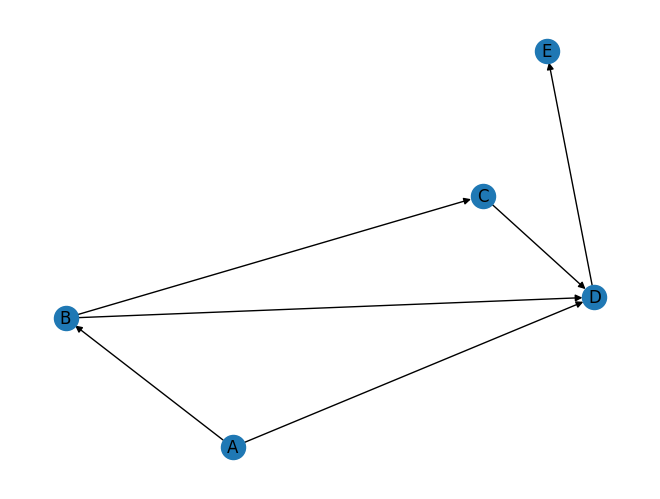

In [9]:
# Create a small graph
G = nx.MultiDiGraph()
edges = [
    ('A', 'B', 5), ('B', 'C', 3), ('C', 'D', 2),
    ('A', 'D', 10), ('B', 'D', 4), ('D', 'E', 1)
]
for u, v, length in edges:
    G.add_edge(u, v, length=length, status='open')

# Vehicle energy params
vehicle_params = {
    'consumption_rate': 1.0  # kWh per km
}
nx.draw(G, with_labels=True)  # Visualize the graph

In [10]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Wrap env to work with SB3
def make_env():
    return EVPathEnv(G, vehicle_params)

vec_env = make_vec_env(make_env, n_envs=1)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=50000)


c:\Users\YODA\AppData\Local\pypoetry\Cache\virtualenvs\ev-energy-optimization-SsceYLpY-py3.12\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\YODA\AppData\Local\pypoetry\Cache\virtualenvs\ev-energy-optimization-SsceYLpY-py3.12\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor 

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7        |
|    ep_rew_mean     | -26      |
| time/              |          |
|    fps             | 684      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7           |
|    ep_rew_mean          | -26         |
| time/                   |             |
|    fps                  | 495         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006058551 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.00286     |
|    learnin

In [ ]:
start_node = 'A'
destination_node = 'E'

# Create raw env
env = EVPathEnv(G, vehicle_params)

# Reset with custom start/destination
obs, _ = env.reset(src=start_node, dst=destination_node)  # this works fine

done = False
path = [start_node]
i=0
while not done:
    # Use your trained model for predictions
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)
    obs, reward, done, _, _ = env.step(action)
    path.append(env.current)
    i+=1
    if i%5000 == 0:
        print(path)
print("Predicted path:", path)


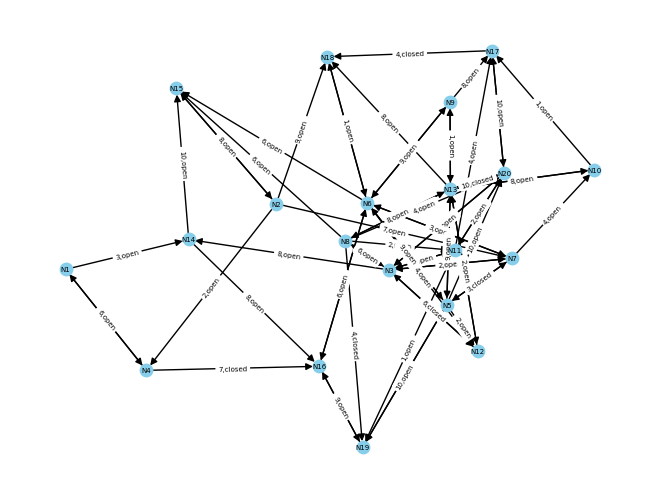

In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# --- Create a more complex graph ---
G = nx.MultiDiGraph()
nodes = [f"N{i}" for i in range(1, 21)]  # 20 nodes

# Add edges with random lengths
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if random.random() < 0.3:  # 30% chance to connect nodes
            length = random.randint(1, 10)
            status = "open" if random.random() < 0.8 else "closed"  # 20% closed
            G.add_edge(nodes[i], nodes[j], length=length, status=status)
            # optionally add reverse edge
            if random.random() < 0.5:
                G.add_edge(nodes[j], nodes[i], length=length, status=status)

# --- Visualize the graph ---
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f"{d['length']},{d['status']}" for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=80, font_size=5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5) 
plt.show()


In [37]:
import gym
from gym import spaces
import numpy as np
import networkx as nx
import random
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Energy function ---
def energy_for_edge(edge_data, vehicle_params):
    length = edge_data.get('length', 1.0)
    return length * vehicle_params.get('consumption_rate', 1.0)

# --- EV Environment ---
class EVPathEnv(gym.Env):
    def __init__(self, G, vehicle_params, seed=0):
        super().__init__()
        self.G = G
        self.vehicle_params = vehicle_params
        self.rng = np.random.default_rng(seed)

        self.nodes = list(G.nodes)
        self.node_to_idx = {n:i for i,n in enumerate(self.nodes)}
        self.idx_to_node = {i:n for n,i in self.node_to_idx.items()}

        n_nodes = len(self.nodes)
        # Observations are normalized floats
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Discrete(n_nodes)

    def reset(self, *, seed=None, options=None, src=None, dst=None):
        super().reset(seed=seed)
        self.src = src if src is not None else self.rng.choice(self.nodes)
        self.dst = dst if dst is not None else self.rng.choice(self.nodes)
        while self.dst == self.src:
            self.dst = self.rng.choice(self.nodes)

        self.current = self.src
        self.total_energy = 0.0
        self.visited = {self.src}
        return self._get_obs(), {}

    def _get_obs(self):
        n_nodes = len(self.nodes)
        return np.array([self.node_to_idx[self.current]/n_nodes,
                         self.node_to_idx[self.dst]/n_nodes], dtype=np.float32)

    def get_valid_actions(self):
        return [self.node_to_idx[n] for n in self.G.neighbors(self.current)]

    def step(self, action):
        next_node = self.idx_to_node[int(action)]
        reward = -1.0
        done = False

        if self.G.has_edge(self.current, next_node):
            edge_data = min(self.G[self.current][next_node].values(),
                            key=lambda d: d.get('length', 9999))
            if edge_data.get('status') == 'closed':
                reward = -10.0
            else:
                e_kwh = energy_for_edge(edge_data, self.vehicle_params)
                reward = -e_kwh
                self.total_energy += e_kwh
                self.current = next_node
                self.visited.add(next_node)
                if self.current == self.dst:
                    done = True
                    reward += 10.0
        else:
            reward = -5.0

        return self._get_obs(), reward, done, False, {}


vehicle_params = {'consumption_rate': 1.0}

# --- Wrap environment for SB3 ---
def make_env():
    return EVPathEnv(G, vehicle_params)

vec_env = DummyVecEnv([make_env])

# --- Train PPO ---
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=50000)




Using cuda device
-----------------------------
| time/              |      |
|    fps             | 759  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0010586423 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -3           |
|    explained_variance   | 6.13e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.9e+03      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00314     |
|    value_loss           | 6.84e+03     |
-----------------------------------------

In [ ]:
# --- Inference with custom start/destination ---
env = EVPathEnv(G, vehicle_params)
start_node = 'N1'
destination_node = 'N15'
obs, _ = env.reset(src=start_node, dst=destination_node)

done = False
path = [start_node]
i=0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)
    # Ensure valid action
    valid_actions = env.get_valid_actions()
    if action not in valid_actions:
        action = env.rng.choice(valid_actions)
    obs, reward, done, truncated, info = env.step(action)
    path.append(env.current)
    i+=1
    if i%9000 == 0:
        print(path)
print("Predicted path:", path)